## Linear Discriminant Analysis(LDA)
LDA can be used for Feature Extraction that can help in increasing the computational efficiency and reduce the degree of overfitting due to the curse of dimensionality. <br>

Unlike PCA,the goal in LDA is to find the feature space that optimizes class separability and also unlike PCA it is a type of Supervised learning algorithm.
![](./images/LDA.png)

A linear discriminant, as shown on the x-axis (LD 1), would separate the two normal distributed classes well. Although the exemplary linear discriminant shown on the y- axis (LD 2) captures a lot of the variance in the dataset, it would fail as a good linear discriminant since it does not capture any of the class-discriminatory information.
<br><br>
**Assumptions in LDA**
1. The data needs to be normally distributed.
2. The Classes have identical covariance matrices.
3. Features are statistically independent of each other.

**Steps involved in LDA**
1. Standardize the d-dimensional dataset.
2. For each class, compute the d-dimensional mean vector.
3. Construct the between-class scatter martix $S_{B}$ and the within-class scatter matrix $S_{w}$
4. Compute the eigenvectors and corresponding eigenvalues of the matrix $S_{w}^{-1}S_{B}$.
5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the k-eigenvectors to transform the data.
7. Project the samples onto a new feature subspace using the transformation matrix **W**.

In [51]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Read the data

In [2]:
df=pd.read_csv('https://archive.ics.uci.edu/ml/' 'machine-learning-databases/wine/wine.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Split the dataset

In [3]:
# Split the data into 80% training and 20% testing
X,y=df.iloc[:,1:].values, df.iloc[:,0].values
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
x_train.shape,x_test.shape

((142, 13), (36, 13))

## 1. Standardize the data

In [4]:
scaler=StandardScaler()
x_train_std=scaler.fit_transform(x_train)
x_test_std=scaler.transform(x_test)

## 2. Computing the scatter matrices
### 2.1 Mean Vectors
Before jumping to scatter matrices we need to find the mean vector, which will then be used to construct scatter matrix and between-class scatter matrix.<br> Mean Vector :-
$$ \left[
\begin{array}
  $\mu_{i,alcohol} \\
  \mu_{i,malic acid} \\
  \vdots \\
  \mu_{i,proline}
\end{array}
\right] $$

In [5]:
mean_vecs=[]

# 3 different labels in the dataset
for label in range(1,4):
    mean_vecs.append(np.mean(x_train_std[y_train==label],axis=0))
    print('MV {}: {}'.format(label,mean_vecs[label-1]))

MV 1: [ 0.91978353 -0.30745801  0.31170497 -0.77070128  0.3570667   0.94244036
  1.08126971 -0.61091043  0.5657055   0.19023193  0.5023533   0.82020082
  1.19673935]
MV 2: [-0.89419108 -0.4180267  -0.46748599  0.22143613 -0.29257833 -0.07476381
  0.03134406 -0.05767259  0.10113134 -0.89096913  0.46438407  0.29201464
 -0.70869344]
MV 3: [ 1.85482156e-01  8.76835219e-01  2.78214421e-01  5.35775485e-01
  5.66825020e-04 -9.11852530e-01 -1.19954906e+00  7.30070523e-01
 -7.38546934e-01  9.62925373e-01 -1.14635768e+00 -1.26118672e+00
 -3.54169803e-01]


### 2.2 Within-Class scatter matrix:
![](./images/SM.png)

In [6]:
mean_vecs[0].shape

(13,)

In [13]:
d=13 # number of features
S_W=np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    class_scatter=np.zeros((d,d))
    for row in x_train_std[y_train==label]:
        row,mv=row.reshape(d,1),mv.reshape(d,1)
        class_scatter+=(row-mv).dot((row-mv).T)
    S_W+=class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


Dividing the Sw by number of classes gives us the covariance matrix.

In [54]:
# Alternative for the inner for loop( Vectorization)
# (x_train_std[y_train==1] - mean_vecs[0]).T.dot(x_train_std[y_train==1] - mean_vecs[0])

### Note:
There is a basic assumption that the class labelled data is uniformly distributed but this is not the case.
Thus we need to scale the individual scatter matrix before we want to sum them up, and when we do that we are actually evaluating the Covariance matrix.<br>
 $$\sum_{i}=\frac{1}{n_{i}}S_{w}=\frac{1}{n_{i}}\sum_{}(x-m_i)(x-m_i)$$

In [11]:
# There is a basic assumption that the class labelled data is uniformly distributed but this is not the case.
# Thus we need to scale the individual scatter matrix before we want to sum them up, and when we do that we are actually 
# evaluating the Covariance matrix.
np.bincount(y_train)[1:]

array([45, 55, 42])

In [16]:
S_W=np.zeros((d,d))
for label in range(1,4):
    class_scatter=np.cov(x_train_std[y_train==label].T)
    S_W+=class_scatter
print('Shape of Scaled within class Scatter matrix :',S_W.shape)

Shape of Scaled within class Scatter matrix : (13, 13)


### 2.3 Between class scatter matrix:
$$S_B=\sum_{i=1}^{c}n_i(m_i-m)(m_i-m)^T$$
where, m = mean of the entire dataset and $m_i$ is the mean of the class label i

In [21]:
mean_overall=np.mean(x_train_std,axis=0)
S_B=np.zeros((d,d))
for i,mean_vec in enumerate(mean_vecs):
    n=x_train_std[y_train==i+1].shape[0]
    mean_vec=mean_vec.reshape(d,1)
    mean_overall=mean_overall.reshape(d,1)
    S_B+=n*(mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print('Between class Scatter matrix shape : ',S_B.shape)

Between class Scatter matrix shape :  (13, 13)


In [18]:
np.unique(y_train)

array([1, 2, 3])

### 2.4 Selecting Linear Discriminants for the new feature subspace
The rest of the steps are similar to PCA but instead of computing eigen values and eigen vectors on Covariance matrix we'll be solving $S_w^{-1}S_B$.

In [40]:
eigen_vals,eigen_vecs=np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs=[(np.abs(eval),evec) for eval,evec in zip(eigen_vals,eigen_vecs)]
eigen_pairs=sorted(eigen_pairs,key=lambda k:k[0],reverse=True)
print('Eigen values in descending order:')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigen values in descending order:
544.9409138254811
187.26591131223125
4.716069852360453e-14
2.986845217823087e-14
2.842170943040401e-14
2.4902697537481495e-14
2.4902697537481495e-14
2.4133016351395774e-14
2.0867089155205042e-14
1.8804853358358074e-14
1.8804853358358074e-14
2.8803848673629816e-15
2.8803848673629816e-15


In [36]:
len(eigen_vals)

13

###  Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
Need to calculate the **variance explained ratios** Given by :-
$$\frac{\lambda_j}{\sum_{j=1}^d\lambda_j}$$

<function matplotlib.pyplot.show(*args, **kw)>

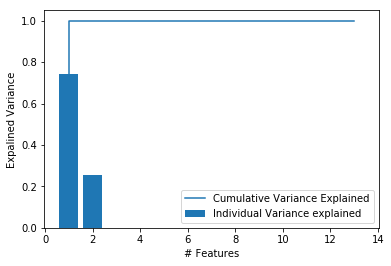

In [54]:
tot_sum=np.sum(eigen_vals.real)
discr=[i/tot_sum for i in sorted(eigen_vals.real,reverse=True)]
cum_sum=np.cumsum(discr)
plt.bar(range(1,14),discr,align='center',label='Individual Variance explained')
plt.step(range(1,14),cum_sum,label='Cumulative Variance Explained')
plt.legend(loc='best')
plt.xlabel('# Features')
plt.ylabel('Expalined Variance')
plt.show

In [55]:
# let's stack the two most discriminative eigen vectors
W=np.hstack((eigen_pairs[0][1][:,np.newaxis].real,eigen_pairs[1][1][:,np.newaxis].real))
print('Matrix W : ',W)

Matrix W :  [[-0.24153337 -0.12924145]
 [-0.38105086 -0.23564322]
 [-0.03002824  0.06602929]
 [ 0.08106218  0.40246235]
 [ 0.17619901  0.11310164]
 [ 0.1564624   0.02484698]
 [ 0.1564624   0.02484698]
 [-0.26092788 -0.08538147]
 [ 0.13557358  0.32076021]
 [-0.19246088 -0.17732492]
 [-0.19246088 -0.17732492]
 [-0.13411033  0.00096329]
 [-0.13411033  0.00096329]]


### 2.5 Projecting samples onto new feature space
$$X^"=XW$$